# GAN 으로의 전환

---


저번 과제에서 이미지 생성과 자연어 처리를 한 모델에서 진행한 것의 연장선이다.

기존의 stable diffusion 의 경우 속도가 느리다는 단점이 있었다. stable diffusion 의 경우 이미지를 여러번 덧칠하는 식으로 그림을 그려나가기 때문이다. 반면 GAN 의 경우 더 빠른 속도로 이미지를 생성할 수 있다.

GAN 으로 이미지 생성 모델을 변경하자 분류 속도는 로컬에서 돌릴 수 있을 정도로 나아졌다. 하지만 GAN 의 학습이 문제였다.

(GAN 코드: https://github.com/raccoonD0G/AIPlus99/blob/main/Homework3/image_gan.py)
(AutoEncoder 코드 : https://github.com/raccoonD0G/AIPlus99/blob/main/Homework3/image_autoencoder.py)

GAN 은 학습 특성상 붕괴 위험이 크고, 학습에 많은 데이터와 에포크가 필요하다. 이는 사전학습된 모델이 있다면 해결된다. 하지만 적합한 사전 학습 모델을 찾지 못해 자체 제작한 GAN 을 사용했다. 이로 인해 GAN 의 퀄리티가 낮았고, 결국 이미지 생성 모델을 섞지 않은 것보다 나쁜 성능이 나왔다.
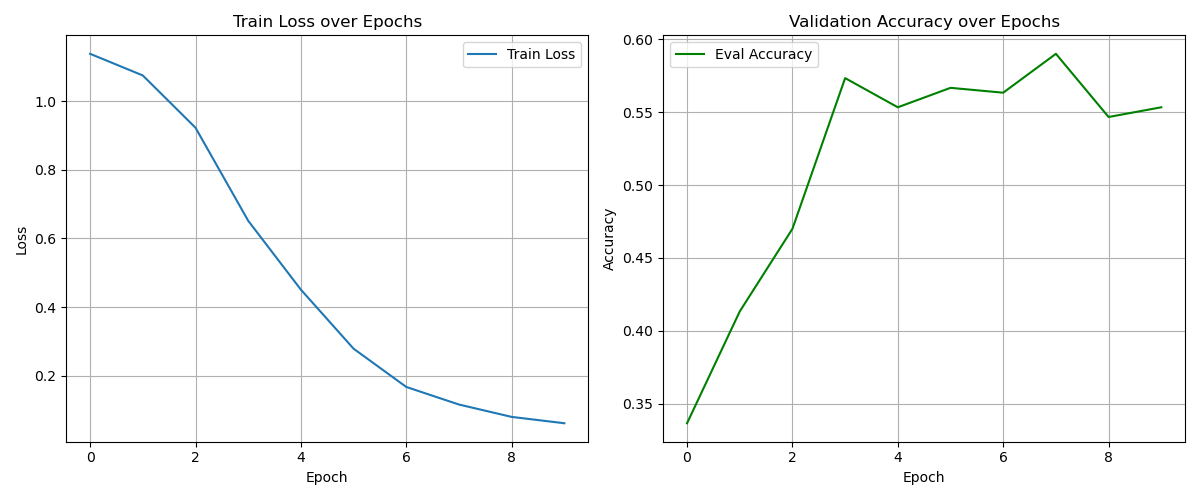

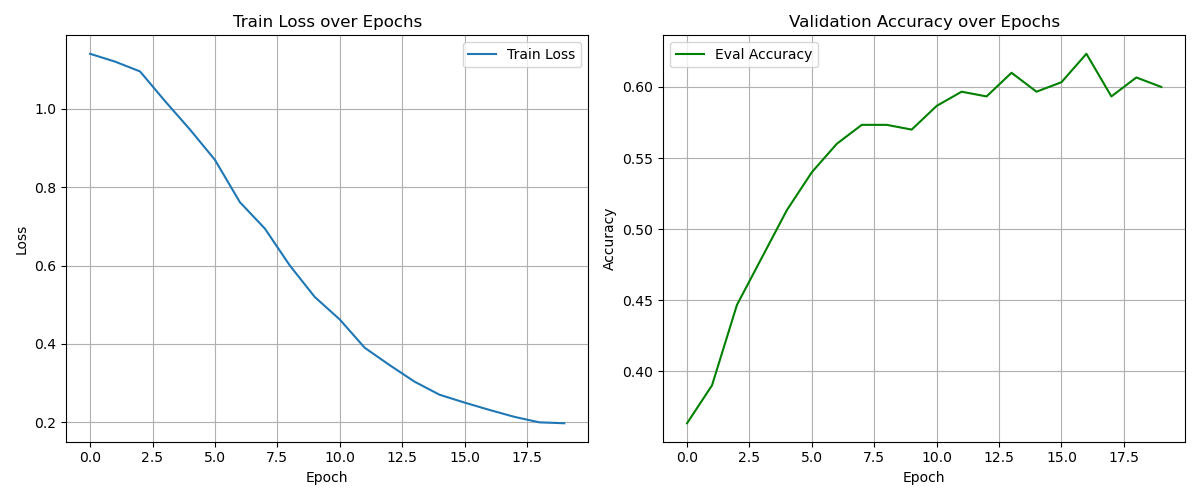

위에 있는 사진이 GAN을 적용한 직후, 아래에 있는 사진이 이미지 생성을 완전히 제거한 상태다. 오히려 이미지 생성을 제거한 상태에서 더 정확도가 높다. 이는 GAN 의 학습이 부족해 충분히 많은 정보를 담지 못했기 때문으로 보인다.

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


에포크 30 기준 Generator 가중치 자동 로드 완료 from 'trained_gan_generator'
에포크 10 기준 가중치 자동 로드 완료 from 'trained_image_autoencoder' : ImageEncoder
에포크 10 기준 가중치 자동 로드 완료 from 'trained_image_autoencoder' : ImageEncoder


Epoch,Training Loss,Validation Loss,Accuracy
1,1.145700,1.101957,0.323000
2,1.142500,1.136477,0.340000
3,1.124000,1.101614,0.352000
4,1.100900,1.082439,0.394000
5,1.044900,1.068490,0.463000
6,0.979000,1.020786,0.497000
7,0.883100,1.142958,0.485000
8,0.799300,1.132049,0.503000
9,0.733400,1.240061,0.517000
10,0.646600,1.284232,0.523000


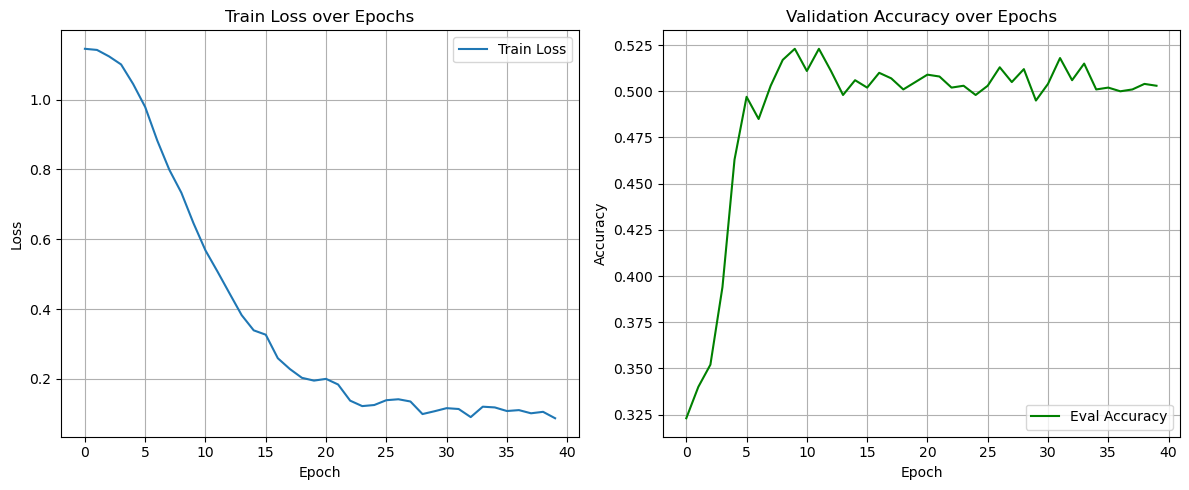

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertModel,
    Trainer,
    TrainingArguments,
    TrainerCallback
)
import matplotlib.pyplot as plt
from image_autoencoder import ImageEncoder
from image_gan import Generator

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        if "loss" in logs:
            self.train_losses.append(logs["loss"])
        if "eval_accuracy" in logs:
            self.eval_accuracies.append(logs["eval_accuracy"])

    def plot(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Train Loss")
        plt.title("Train Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.eval_accuracies, label="Eval Accuracy", color="green")
        plt.title("Validation Accuracy over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

class CrossAttention(nn.Module):
    def __init__(self, dim=768, heads=8, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)

        self.ln1_pre = nn.LayerNorm(dim)
        self.ln1_post = nn.LayerNorm(dim)

        self.ln2_pre = nn.LayerNorm(dim)
        self.ln2_post = nn.LayerNorm(dim)

        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )

    def forward(self, query_feat, context_feat):
        query_norm = self.ln1_pre(query_feat)
        context_norm = self.ln1_pre(context_feat)

        attn_out, _ = self.attn(query=query_norm, key=context_norm, value=context_norm)
        x = self.ln1_post(attn_out + query_feat)  # Residual + LayerNorm

        ffn_in = self.ln2_pre(x)
        ffn_out = self.ffn(ffn_in)
        out = self.ln2_post(ffn_out + x)  # Residual + LayerNorm

        return out

class SimpleTextToImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        for param in self.bert.parameters():
            param.requires_grad = False

        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.generator = Generator().to("cuda")
        self.image_encoder = ImageEncoder().to("cuda")

        image_encoder_weight_path = "trained_image_autoencoder"
        self.image_encoder._try_load_weights(image_encoder_weight_path, "cuda")

        for param in self.image_encoder.parameters():
            param.requires_grad = True

        self.ln_image = nn.LayerNorm(768)
        self.ln_text = nn.LayerNorm(768)

        self.cross_attn_ti = nn.ModuleList([
            CrossAttention(),
            CrossAttention(),
            CrossAttention()
        ])

        self.cross_attn_it = nn.ModuleList([
            CrossAttention(),
            CrossAttention(),
            CrossAttention()
        ])

        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, 3)
        )

        self.img_projector = nn.Sequential(
            nn.Linear(1024, 768),
            nn.LayerNorm(768),
            nn.LeakyReLU(0.1),
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        bert_outputs = self.ln_text(bert_outputs)

        fake_imgs = self.generator(bert_outputs)

        img_tensors = nn.functional.interpolate(fake_imgs, size=(224, 224), mode="bilinear", align_corners=False)
        img_features = self.image_encoder(img_tensors)
        img_features = self.img_projector(img_features)
        img_features = self.ln_image(img_features)
        img_features = self.ln_image(img_features)

        text_feat = bert_outputs.unsqueeze(1)
        image_feat = img_features.unsqueeze(1)

        for layer in self.cross_attn_ti:
            text_feat = layer(text_feat, image_feat)

        for layer in self.cross_attn_it:
            image_feat = layer(image_feat, text_feat)

        fused = torch.cat([text_feat.squeeze(1), image_feat.squeeze(1)], dim=-1)
        logits = self.classifier(fused)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return loss, logits

        return logits

# MNLI 데이터셋 불러오기
train_data = load_dataset("nyu-mll/glue", "mnli", split="train[:1000]")
val_data = load_dataset("nyu-mll/glue", "mnli", split="validation_matched[:1000]")


# 라벨 맵핑 (0: entailment, 1: neutral, 2: contradiction)
label_map = {"entailment": 0, "neutral": 1, "contradiction": 2}

# 사용자 정의 Dataset 클래스
class MNLIDataset(Dataset):
    def __init__(self, data):
        self.examples = []
        for ex in data:
            text = f"{ex['premise']} [SEP] {ex['hypothesis']}"
            encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
            self.examples.append({
                "input_ids": encoding["input_ids"].squeeze(0),
                "attention_mask": encoding["attention_mask"].squeeze(0),
                "labels": torch.tensor(ex["label"])
            })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

# Trainer에서 사용할 compute_metrics 함수
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    acc = (preds == torch.tensor(labels)).float().mean().item()
    return {"accuracy": acc}


# 학습 인자
training_args = TrainingArguments(
    output_dir="hf_transformer",
    num_train_epochs=40,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    do_train=True,
    do_eval=True,
    load_best_model_at_end=True,
    save_total_limit=1
)

# 모델 준비
model = SimpleTextToImageClassifier().to("cuda")

# Trainer 정의
logger = LoggingCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=MNLIDataset(train_data),
    eval_dataset=MNLIDataset(val_data),
    compute_metrics=compute_metrics,
    callbacks=[logger]  # 콜백 등록
)

# 학습 실행
trainer.train()

# 학습 이후 그래프 출력
logger.plot()
